# Training a flood prediction model
In this second notebook, we use the training dataset created in [02_Creating_Training_Data.ipynb](https://github.com/twaldburger/flood475/blob/master/02_Creating_Training_Data.ipynb) to train a flood prediction model
> **Task:** Tsk and questions are marked like this. Please try to answer them before proceeding with the next cell.

---
## Preparations

### Install additional dependencies
Not all our required libraries are pre-installed in Colab. We therefore install additional libraries using [pip](https://pip.pypa.io/en/stable/). After installation, we have to restart our runtime before we can import the library. Please make sure that you click the _RESTART SESSION_-button which is displayed at the end of the code cell's output.

In [1]:
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s et

### Import dependencies
We can now import all required dependencies.

In [1]:
import google
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from geemap.legends import builtin_legends
from pathlib import Path
from pycaret.classification import *

### Define global variables
The cell below defines some global variables.
- `TRAINING_DATA` This is the name of the dataset we created in [01_Connecting_to_GEE.ipynb](https://github.com/twaldburger/flood475/blob/master/02_Creating_Training_Data.ipynb). You do not have to specify the path but only the file name which is most likely _roi_sample.csv_ or _floods_sample.csv_.
- `SEED` This is the seed value used for splitting our training data into a train and a test dataset. Setting this value makes our results reproducible.

In [2]:
TRAINING_DATA = 'roi_sample.csv' # @param {type: 'string'}
SEED = 123 # @param {type: 'integer'}

### Mount Google Drive
We will use Google Drive to store our preliminary results from GEE because we can mount it to Google Colab and therefore easily write and read data without the need of manually down- and uploading datasets.

**Important!** The cell below mounts your Google Drive to Google Colab and creates a new folder (named _geo475_ee_). This folder will be removed again at the end of the exercise (you can also keep it if you want, of course). **To make sure that we are not deleting any of your personal data, do not change the `data_dir`-variable in the cell below unless you know what you are doing.**

In [3]:
data_dir = Path('/content/gdrive/MyDrive/geo475_ee')

## mount Google Drive to Colab
if not data_dir.parent.exists():
  google.colab.drive.mount('/content/gdrive')

## create output directory for the project
if not data_dir.exists():
  data_dir.mkdir()

Mounted at /content/gdrive


---
## Data preparation

### Data import
First, we import our training dataset from Google Drive and remove unnecessary columns.

In [5]:
## import from google drive
df = pd.read_csv(data_dir/TRAINING_DATA)

## make target variable binary
df['flooded'] = 0
df.loc[df['floods']>0, 'flooded'] = 1

## remove unnecessary columns
df.drop(['floods', 'system:index', 'first', '.geo'], axis=1, inplace=True)

### Exploratory data analysis
We now have a first look at the columns in the dataframe.
> **Task:** Look at the descriptive statistics and see if you spot anything unexpected. What are your key observations?

In [6]:
## get descriptive statistics of all columns
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
aspect,755.0,160.244757,34.102954,103.509230,103.509230,180.000000,180.000000,183.647098
daily_max_precipitation_-18,755.0,93.117169,15.196346,56.266155,93.646683,101.480400,101.480400,101.480400
daily_max_precipitation_-17,755.0,56.820757,8.198378,44.331783,54.185772,54.185772,69.306183,69.306183
daily_max_precipitation_-16,755.0,58.514038,2.167114,55.242165,57.806240,57.806240,61.824318,61.824318
daily_max_precipitation_-15,755.0,62.212959,3.237367,60.216000,60.216000,60.216000,67.599777,67.599777
daily_max_precipitation_-14,755.0,58.644767,10.059563,38.669708,57.524361,57.524361,71.652588,71.652588
daily_max_precipitation_-13,755.0,75.808700,11.251892,57.556225,57.556225,83.809494,83.809494,83.809494
daily_max_precipitation_-12,755.0,65.963524,9.065164,54.043064,54.043064,73.389069,73.389069,73.389069
daily_max_precipitation_-11,755.0,51.627088,11.318312,35.656475,39.151329,60.898346,60.898346,60.898346
daily_max_precipitation_-10,755.0,62.850430,14.241200,52.519878,52.519878,52.519878,70.437515,92.672630


Let's check how flood frequency is distributed and how it relates to landcover by creating a stacked barplot showing the flood frequency counts per landcover class.
> **Task:** Try to answer the following questions:
1. What are your key observations when looking at the barplot?
2. Does the plot make sense? Do you see anything unexpected?
3. Do you see signs of biased or wrong training data?

<AxesSubplot: xlabel='flooded'>

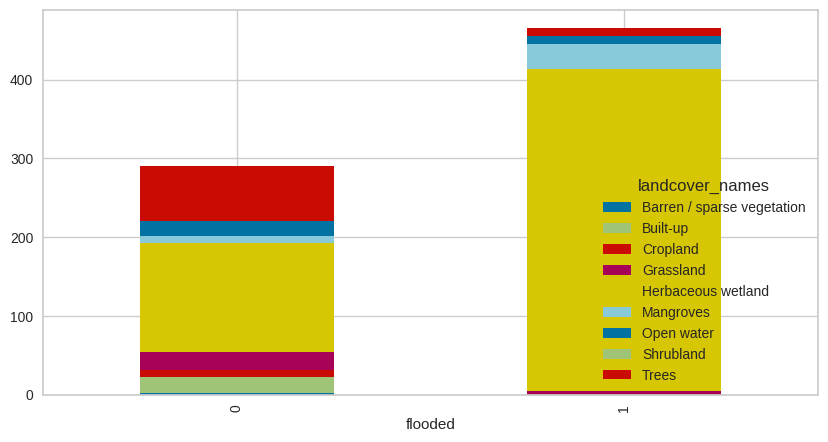

In [7]:
## create a mapper to assign landcover class names
mapper = {}
for cls in builtin_legends['ESA_WorldCover']:
  k, v = cls.split(' ', 1)
  mapper[float(k)] = v
df['landcover_names'] = df['landcover'].map(mapper)

## stacked barplot showing flood frequency counts per landcover class
df_plot = df.groupby(['landcover_names', 'flooded']).size().reset_index()
df_plot = df_plot.pivot(columns='landcover_names', index='flooded', values=0)
df.drop(['landcover_names'], axis=1, inplace=True)
df_plot.plot(kind='bar', stacked=True, figsize=(10, 5))

> **Task:** Which other training variables are you interested in exploring? Try to create a few more plots to get an idea of your training dataset.

Next, let's have a look at correlations with our target variable.
> **Task:** Do you see any strong correlations? How could we use a high correlation to our benefit?

In [8]:
corr = df.corr(method='pearson')
corr['flooded'].sort_values(ascending=False)

flooded                        1.000000
landcover                      0.482393
daily_max_precipitation_-18    0.249669
daily_max_precipitation_-6     0.235389
daily_max_precipitation_-3     0.226130
daily_max_precipitation_-9     0.225042
daily_max_precipitation_-14    0.208268
daily_max_precipitation_-0     0.185494
daily_max_precipitation_-5     0.168363
daily_max_precipitation_-17    0.161383
daily_max_precipitation_-16    0.160002
daily_max_precipitation_-4     0.151543
daily_max_precipitation_-11    0.141877
daily_max_precipitation_-12    0.099533
daily_max_precipitation_-8     0.095271
daily_max_precipitation_-15    0.059150
upstream_drainage_area         0.015925
daily_max_precipitation_-7     0.009502
daily_max_precipitation_-13   -0.009279
aspect                        -0.075659
daily_max_precipitation_-2    -0.198631
daily_max_precipitation_-1    -0.204996
daily_max_precipitation_-10   -0.213895
slope                         -0.250721
elevation                     -0.400549


And also at the correlations between all other variables.
> **Task:** Try to answer the following questions:
1. Between which variables do you see (strong) correlation?
2. To what extent does it make sense to look at the correlation? Where do you see potential problems?

<AxesSubplot: >

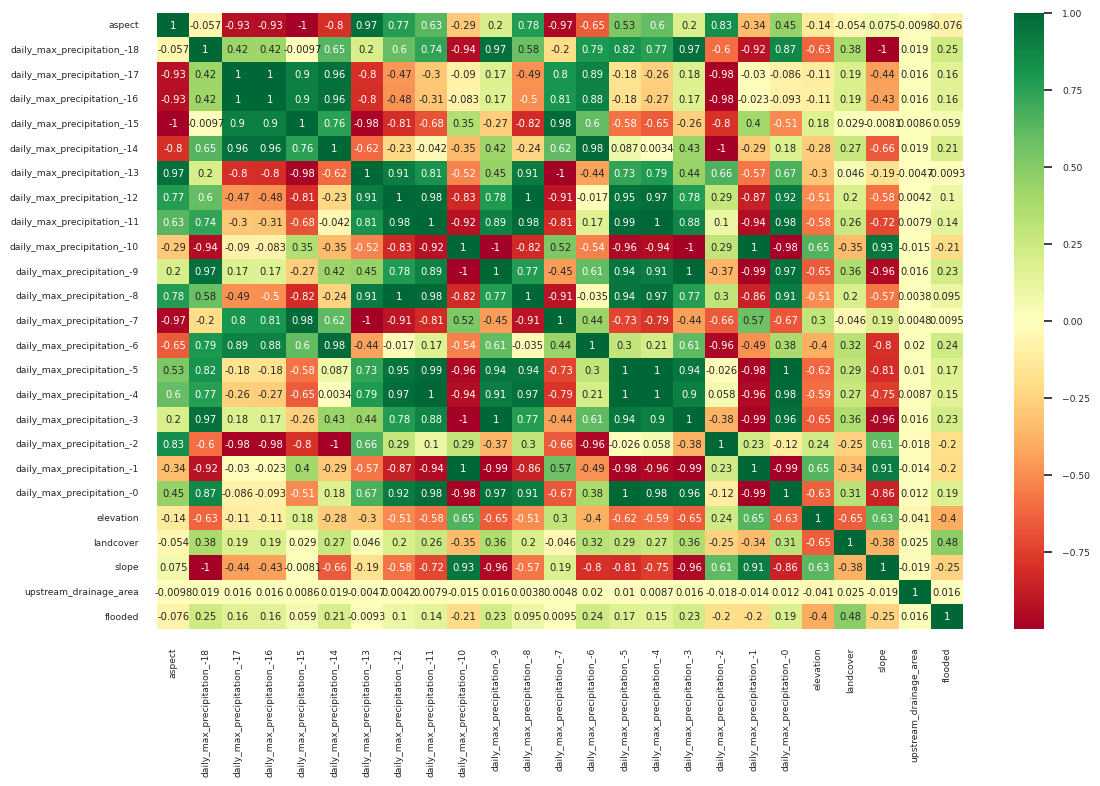

In [9]:
# quantify correlations between all variables
plt.figure(figsize=(13, 8))
sns.set(font_scale=0.6)
sns.heatmap(corr, cmap='RdYlGn', annot=True, center=0, fmt=".2g")

### Feature engineering
We saw that _daily_max_precipitation_ is strongly correlated in many columns. We therefore create a new variable by aggregating all _daily_max_precipitation_ using the mean.

In [10]:
cols = [c for c in df.columns if c.startswith('daily_max')]
df['daily_max_precipitation'] = df[cols].mean(axis=1)
df.drop(cols, axis=1, inplace=True)
df

,aspect,elevation,landcover,slope,upstream_drainage_area,flooded,daily_max_precipitation
1,180.00000,1.500000,50,0.000754,0.108012,0,72.445895
2,103.50923,3.026255,90,0.002751,1.122413,1,66.987826
4,180.00000,-0.151968,90,0.000754,0.046434,1,72.445895
5,103.50923,2.000000,90,0.002751,0.007696,1,66.987826
6,180.00000,1.463089,90,0.000754,0.023147,0,72.445895
...,...,...,...,...,...,...,...
994,180.00000,0.054698,90,0.000754,0.007736,1,72.445895
995,103.50923,3.667277,90,0.002751,0.007677,1,66.987826
996,180.00000,3.968496,90,0.000754,0.108236,1,72.445895
997,180.00000,0.594885,95,0.000754,0.007749,1,72.445895


---
## Model training


### Setup
With this function, we initialize the training environment. We are using the absolute minimum for the setup by only defining the required parameters. However, the customization options are almost endless.
> **Task:** Come back to this cell after your initial run and try if you can get better results by adjusting your training environment. You can find the documentation for the _setup_-method [here](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.ClassificationExperiment).

In [11]:
classifier = setup(data=df, target='flooded', session_id=SEED)

,Description,Value
0,Session id,123
1,Target,flooded
2,Target type,Binary
3,Original data shape,"(755, 7)"
4,Transformed data shape,"(755, 7)"
5,Transformed train set shape,"(528, 7)"
6,Transformed test set shape,"(227, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


### Compare models
We now train and evaluate multiple models. The visualisation of this function is a scoring grid with average cross-validated scores. The output stored in `best` is the highest scoring model. Here, we want to focus on the following metrics:

- _Accuracy:_ How often is the model right?
- _Recall:_ How many positive predictions can the model identify?
- _Precision:_ How often are positive predictions correct?
- _F1-Score:_ Combination of recall and precision. A high F1-score signifies that the model can effectively identify positive cases while minimizing false positives and false negatives.

> **Task:** Conduct a short internet research to learn a little bit about the type of model which scored best for your training data. Then, try to answer the following questions:
1. How high is your best model's accuracy? Do you think this is a good performance?
2. When looking at the other metrics, would you argue that another model actually performs better than the one with the highest accuracy?

In [12]:
best = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7484,0.0000,0.9634,0.7238,0.8258,0.4061,0.4649,0.0170
lda,Linear Discriminant Analysis,0.7484,0.7673,0.9634,0.7238,0.8258,0.4061,0.4649,0.0170
lr,Logistic Regression,0.7484,0.7668,0.9481,0.7289,0.8233,0.4127,0.4612,0.3670
ada,Ada Boost Classifier,0.7672,0.8019,0.8775,0.7779,0.8228,0.4870,0.5010,0.0790
knn,K Neighbors Classifier,0.7673,0.7839,0.8402,0.7972,0.8165,0.4978,0.5027,0.0310
lightgbm,Light Gradient Boosting Machine,0.7635,0.8051,0.8313,0.7969,0.8117,0.4937,0.4998,0.7730
rf,Random Forest Classifier,0.7579,0.8011,0.8314,0.7914,0.8085,0.4796,0.4863,0.1490
xgboost,Extreme Gradient Boosting,0.7597,0.8026,0.8222,0.7969,0.8077,0.4873,0.4917,0.0740
gbc,Gradient Boosting Classifier,0.7483,0.8044,0.8497,0.7712,0.8058,0.4494,0.4611,0.0760
nb,Naive Bayes,0.7350,0.7882,0.8892,0.7379,0.8054,0.4009,0.4222,0.0180


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### Analyze best model
We now focus on the model with the highest F1-score and plot the confusion matrix by running the cell below. Below is a quick refresher on the 4 fields of the confusion matrix but it is also worth to have a look at [this page](https://www.v7labs.com/blog/confusion-matrix-guide) which shows how the metrics from above link to the confusion matrix.

- _True Positive (TP):_ a class is predicted true and is true in reality (locations that are flooded and are predicted as flooded)
- _True Negative (TN):_ a class is predicted false and is false in reality (locations that not flooded and are predicted as not flooded)
- _False Positive (FP):_ a class is predicted true but is false in reality (locations that are not flooded but are predicted as flooded)
- _False Negative (FN):_ a class is predicted false but is true in reality (locations that are flooded but predicted as not flooded)

> **Task:** Try to answer the following questions:
1. What can you read from the confusion matrix of your model?
2. Does your model perform better when correctly predicting flooded locatations or does it perform better when correctly predicting non-flooded locations.
3. Thinking about risk and insurance, which of the 4 fields do think is most important?
4. Thinking about risk and insurance, what does a high number of false negatives mean?
5. Thinking about risk and insurance, what does a high number of false positives mean?



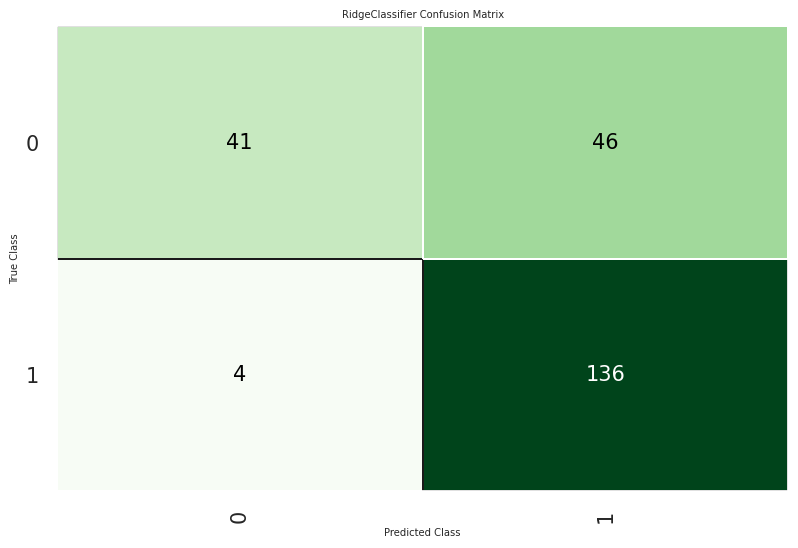

In [13]:
plot_model(best, plot='confusion_matrix')

We will also have a look at the importance of our input variables.
> **Task:** Try to answer the following questions:
1. Which features are more important and which are less important?
2. How could we use this information to improve our pipeline?
3. How could the selection of our training data (and our region of interest) influence feature importance?


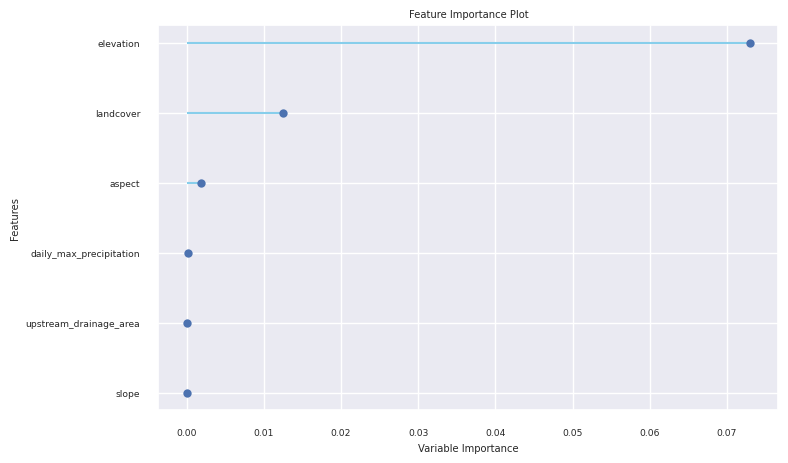

In [14]:
plot_model(best, plot='feature')